# Récupération des données

## Pour un spectacle donné

In [26]:
import urllib.request
import re
import pandas as pd
import os
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup
#spectacleId="37982"

#here id example with inside <p> <span class="n"> spectacleId="60720"
spectacleId="723"
#spectacleId="60720"
#spectacleId="36956"
#spectacleId="20185"
# specify which URL/web page we are going to be scraping
url = "https://www.lesarchivesduspectacle.net/?IDX_Spectacle=" + spectacleId
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")
#the div where the information is
#the div where the information is
div_interested = soup.find('div', class_='fiche__footer') 
column_label=[]
column_value=[]
for row in div_interested.find_all('table')[0].findAll('tr'):
    th = row.findAll('th')[0].contents[0]
    td = row.findAll('td')[0].contents[0]
    column_label.append(th)
    column_value.append(td)
new_table = pd.DataFrame(columns=column_label, index= [0]) # I know the size
new_table["spectacleId"]=int(spectacleId)
for row in div_interested.find_all('table')[0].findAll('tr'):
    th = row.findAll('th')[0].contents[0]
    td = row.findAll('td')[0].contents[0].strip()
    new_table.at[0,th] = td
#Recuperer creation_date - organism_creation 
#the div where the information is
div_spectacle = soup.find('div', id='div_Spectacle')
p_spectacle = div_spectacle.find_all('p')[0]
if(p_spectacle) != None :
    for time in p_spectacle.findAll('time'):
        if time.has_attr('datetime'):
            new_table["typeDate"]=time.previousSibling
            new_table["date"]=time['datetime']
    for organism in p_spectacle.findAll('a',class_ ='c_Organisme'):
        if organism.has_attr('href'):
            new_table["organismeId"]=organism['href']
            new_table["organismeName"]=organism.contents[0].strip()
    if p_spectacle.find_all('span'):
        first = next(p_spectacle.stripped_strings)
        new_table["to_analyse"]=first
    else:
        new_table["to_analyse"]=p_spectacle.contents[0].string.strip()
#partie sur la taille des équipes
possible_job=['Danse','Circassien']
nb_equipe=len(soup.find_all('table', class_='f-spectacle__equipe'))
nb_danseurs=0
job_rowid = {}
id_row_dance_start=0
if nb_equipe > 1:
    nb_reprise=nb_equipe-1
    new_table["nombre reprise"]=nb_reprise
    #on regarde si reprise
    reprise_div=soup.find_all('div', id='onglets-reprise')
    if reprise_div:
        rows=soup.find_all('table',class_='f-spectacle__equipe')[1].findAll('tr')
        for i in range(len(rows)):
            th_all = rows[i].findAll('th')
            #on récupère le nombre de row par métiers et la ligne danse
            for th in th_all:
                job_rowid[i] = th.getText()
                #find the row for the possible_job
                if any(x in th.getText() for x in possible_job):
                    id_row_dance_start=i    
        keys = list(job_rowid) 
        if len(keys)>1:
            id_row_dance_end = keys[keys.index(id_row_dance_start) + 1] 
            rows=soup.find_all('table', class_='f-spectacle__equipe')[1].findAll('tr')
            for j in range(len(rows)):
                if j>=id_row_dance_start and j<id_row_dance_end:
                    #parfois <span class="c_Commentaire">24 danseurs</span>
                    span=rows[j].find('span',class_ ='c_Commentaire')
                    if span:
                        new_table["commentaire"]=span.getText()
                    anchor=rows[j].find('a',class_ ='c_Personne b')
                    if anchor:
                        nb_danseurs += 1
        else:
            new_table["commentaire"]="problem qu'un élément métier"                  
if nb_equipe == 1:
    rows=soup.find_all('table')[0].findAll('tr')
    for i in range(len(rows)):
        th_all = rows[i].findAll('th')
        #on récupère le nombre de row par métiers et la ligne danse
        for th in th_all:
            job_rowid[i] = th.getText()
            #find the row for the possible_job
            if any(x in th.getText() for x in possible_job):
                id_row_dance_start=i
    if id_row_dance_start!=0:
        keys = list(job_rowid) 
        id_row_dance_end = keys[keys.index(id_row_dance_start) + 1] 
        rows=soup.find_all('table')[0].findAll('tr')
        for j in range(len(rows)):
            if j>=id_row_dance_start and j<id_row_dance_end:
                #parfois <span class="c_Commentaire">24 danseurs</span>
                span=rows[j].find('span',class_ ='c_Commentaire')
                if span:
                    new_table["commentaire"]=span.getText()
                anchor=rows[j].find('a',class_ ='c_Personne b')
                if anchor:
                    nb_danseurs += 1
    else:
         new_table["commentaire"]="pas de job danse"        
new_table["nb danseur"]=nb_danseurs  
new_table



,Genre,Pays,spectacleId,to_analyse,nombre reprise,commentaire,nb danseur
0,Danse,France,723,Création 2004,1,problem qu'un élément métier,0


## Fonction pour récupérer les informations liées à un spectacle


In [1]:
import urllib.request
import re
from bs4 import BeautifulSoup
import pandas as pd
import socket, errno
import sys

def import_df_type_spectacle(spectacleId):
    # specify which URL/web page we are going to be scraping
    url = "https://www.lesarchivesduspectacle.net/?IDX_Spectacle=" + str(spectacleId)    
    try:
        if spectacleId != 0:
            # open the url using urllib.request and put the HTML into the page variable
            page = urllib.request.urlopen(url)
            # parse the HTML from our URL into the BeautifulSoup parse tree format
            soup = BeautifulSoup(page, "lxml")
            div_interested = soup.find('div', class_='fiche__footer') 
            column_label=[]
            column_value=[]
            for row in div_interested.find_all('table')[0].findAll('tr'):
                th = row.findAll('th')[0].contents[0]
                td = row.findAll('td')[0].contents[0]
                column_label.append(th)
                column_value.append(td)
            new_table = pd.DataFrame(columns=column_label, index= [0]) # I know the size
            new_table["spectacleId"]=int(spectacleId)
            for row in div_interested.find_all('table')[0].findAll('tr'):
                th = row.findAll('th')[0].contents[0]
                td = row.findAll('td')[0].contents[0].strip()
                new_table.at[0,th] = td
            #Recuperer creation_date - organism_creation 
            #the div where the information is
            div_spectacle = soup.find('div', id='div_Spectacle')
            p_spectacle = div_spectacle.find_all('p')[0]
            if(p_spectacle) != None :
                for time in p_spectacle.findAll('time'):
                    if time.has_attr('datetime'):
                        new_table["typeDate"]=time.previousSibling
                        new_table["date"]=time['datetime']
                for organism in p_spectacle.findAll('a',class_ ='c_Organisme'):
                    if organism.has_attr('href'):
                        new_table["organismeId"]=organism['href']
                        new_table["organismeName"]=organism.contents[0].strip()
                if p_spectacle.find_all('span'):
                    first = next(p_spectacle.stripped_strings)
                    new_table["to_analyse"]=first
                else:
                    new_table["to_analyse"]=p_spectacle.contents[0].string.strip()
            return new_table
    except urllib.error.URLError as e:
        print(e.reason + "for spectacleId "  + str(spectacleId))
    except socket.timeout as e: # <-------- this block here
        print("We timed out")
    except Exception as e:
        print("Unexpected error for " + str(spectacleId) + " spectacle id "+ str(e))
        raise 





## Récupération des informations spectacles pour un organisme

In [22]:
import urllib.request
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
from datetime import datetime
import pandas as pd
import os
import socket, errno
import numpy as np
# 439 Arsenal
# 699 CCAM
# 383 grand theatre 
# 1914 CARREAU

organismId="1914"
print("start",datetime.now()) 
path=os.getcwd() + "/data/"
csv_file_path = path + "all_10_years_organism_" + organismId + "_clean.csv"

df = pd.read_csv(csv_file_path)
#in case of several representation for a same performence 53079
t_array = np.unique(df["performanceId"].to_numpy())

frames = [ import_df_type_spectacle(f) for f in t_array ]
result = pd.concat(frames)
result.set_index(['spectacleId'], drop=True, inplace=True)
result.to_csv(os.path.join(path,'all_10_years_organism_' + organismId + '_unique_clean_type_spectacle.csv'))
print("finish",datetime.now())



start 2020-08-23 16:57:41.373082
finish 2020-08-23 16:59:31.553471


# Filtre sur les spectacles de danse



## Répartition par genre

La base de données référencent les spectacles théâtre - danse - danse jeune public
A voir pour une évolution des spectacles jeune public

### Arsenal

In [27]:
import os
import pandas as pd
organismId="439"
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_type_spectacle.csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
#df_spectacle.groupby("Genre")["spectacleId"].count().sort_values(ascending=False)

Le jeune public

In [11]:
df_spectacle_arsenal

,spectacleId,Genre,Durée,Pays,typeDate,date,organismeId,organismeName,to_analyse
0,23453,Danse,1 heure,Belgique,Création le,2010-04-27,?IDX_Organisme=934&Saison=2009,Théâtre Royal de la Monnaie,Création le
1,30546,Théâtre – Musique,NaN,France,NaN,NaN,NaN,NaN,Création 2010
2,19502,Danse,1 heure 20,États-Unis,Création le,2009-09-25,NaN,NaN,Création le
3,12451,Danse – Jeune public – à partir de 6 ans,NaN,France,NaN,NaN,NaN,NaN,Création 2008
4,20185,Danse – à partir de 7 ans,1 heure,France,Création le,2009-11-03,?IDX_Organisme=837&Saison=2009,Maison de la Danse de Lyon,Création le
...,...,...,...,...,...,...,...,...,...
190,90791,Danse – Musique – à partir de 12 ans,1 heure,France,NaN,NaN,NaN,NaN,NaN
191,83385,Danse – Jeune public – jusqu'à 2 ans,25 minutes,France,NaN,NaN,NaN,NaN,Création 2017
192,84175,Danse – à partir de 7 ans,45 minutes,Suisse,Création le,2017-10-25,?IDX_Organisme=2254&Saison=2017,Le Petit Théâtre,Création le
193,88311,Danse – Musique – à partir de 10 ans,1 heure 35,Burkina Faso,Création le,2018-06-29,?IDX_Organisme=436&Annee=2018,La Friche La Belle de Mai,Création le


In [28]:
import re
#Filtre sur le genre - string contains danse
df_danse_arsenal=df_spectacle_arsenal[df_spectacle_arsenal['Genre'].astype(str).str.contains("Danse",flags=re.IGNORECASE, regex=True)]
len(df_danse_arsenal)

124

In [83]:
#Sur la danse - compte spectacle jeune public 
import re
df_danse_arsenal_jeune=df_danse_arsenal[df_danse_arsenal['Genre'].astype(str).str.contains("Jeune public|à partir",flags=re.IGNORECASE, regex=True)]
# 51 spectacles len(df_danse_arsenal_jeune)
part_jeune_arsenal=len(df_danse_arsenal_jeune)*100/len(df_danse_arsenal)
part_jeune_arsenal

41.12903225806452

### Grand théâtre

In [21]:
import time
import os
from datetime import datetime
import pandas as pd
organismId="383"


csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_type_spectacle.csv"
df_spectacle_lux = pd.read_csv(csv_file_path)
#Filtre sur le genre - string contains danse

df_danse_lux=df_spectacle_lux[df_spectacle_lux['Genre'].astype(str).str.contains("Danse")]
len(df_danse_lux)

207

In [85]:
#Sur la danse - compte spectacle jeune public 
import re
df_danse_lux_jeune=df_danse_lux[df_danse_lux['Genre'].astype(str).str.contains("Jeune public|à partir",flags=re.IGNORECASE, regex=True)]
part_jeune_lux=len(df_danse_lux_jeune)*100/len(df_danse_lux)
part_jeune_lux


18.357487922705314

### CCAM

In [23]:
import time
import os
from datetime import datetime
import pandas as pd
organismId="699"


csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_type_spectacle.csv"
df_spectacle_ccam = pd.read_csv(csv_file_path)
#Filtre sur le genre - string contains danse

df_danse_ccam=df_spectacle_ccam[df_spectacle_ccam['Genre'].astype(str).str.contains("Danse")]
df_danse_ccam

,spectacleId,Genre,Pays,typeDate,date,organismeId,organismeName,to_analyse,Durée
6,29201,Danse,France,NaN,NaN,NaN,NaN,Création 2010,NaN
9,29203,Danse,France,Création le,2011-02-02,?IDX_Organisme=699&Saison=2010,CCAM,Création le,NaN
15,27906,Danse,France,Création le,2010-10-01,?IDX_Organisme=1342&Annee=2010,Théâtre du Point du Jour,Création le,NaN
20,29208,Danse,France,NaN,NaN,NaN,NaN,Création 2010,NaN
41,37959,Danse – Jeune public – à partir de 5 ans,France,Création le,2012-01-12,?IDX_Organisme=953&Saison=2011,Théâtre Brétigny,Création le,50 minutes
...,...,...,...,...,...,...,...,...,...
283,2579,Danse,France,Création le,2007-06-24,?IDX_Organisme=339&Annee=2007,Chai du Terral,Création le,1 heure
284,59223,Danse,France,Création le,2012-03-27,?IDX_Organisme=9286&Annee=2012,Théâtre de Vanves,Création le,55 minutes
286,99502,Danse,France,NaN,NaN,NaN,NaN,NaN,50 minutes
290,90781,Danse – Musique,France,NaN,NaN,NaN,NaN,NaN,50 minutes


In [87]:
#Sur la danse - compte spectacle jeune public 
import re
df_danse_ccam_jeune=df_danse_ccam[df_danse_ccam['Genre'].astype(str).str.contains("Jeune public|à partir",flags=re.IGNORECASE, regex=True)]
part_jeune_ccam=len(df_danse_ccam_jeune)*100/len(df_danse_ccam)
part_jeune_ccam

36.0

### Carreau

In [25]:
import time
import os
from datetime import datetime
import pandas as pd
organismId="1914"


csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_type_spectacle.csv"
df_spectacle_carreau = pd.read_csv(csv_file_path)
#Filtre sur le genre - string contains danse

df_danse_carreau=df_spectacle_carreau[df_spectacle_carreau['Genre'].astype(str).str.contains("Danse")]
df_danse_carreau

,spectacleId,Genre,Pays,typeDate,date,organismeId,organismeName,to_analyse,Durée
3,27687,Danse – Musique – à partir de 6 ans,France,Création le,2010-09-25,?IDX_Organisme=1342&Annee=2010,Maison de la Danse de Lyon,Création le,1 heure 5
7,10120,Danse,Belgique,NaN,NaN,NaN,NaN,Création 2008,NaN
10,21054,Théâtre – Danse – Jeune public – à partir de 7...,France,Création le,2010-01-19,?IDX_Organisme=1022&Saison=2009,Théâtre des Cordes,Création le,55 minutes
12,27180,Théâtre – Danse,Belgique,Création le,2010-07-09,?IDX_Organisme=2776&Annee=2010,Salle de spectacle de Vedène,Création le,NaN
20,12382,Danse,France,Création le,2009-01-17,?IDX_Organisme=1593&Saison=2008,Théâtre de la Cité Internationale,Création le,NaN
...,...,...,...,...,...,...,...,...,...
218,94433,Danse,Belgique,Création le,2018-03-22,?IDX_Organisme=12755&Saison=2017,Les Brigittines,Création le,1 heure 15
219,89074,Danse,Belgique,Création le,2018-10-20,?IDX_Organisme=2113&Saison=2018,Koninklijke Vlaamse Schouwburg,Création le,1 heure 45
221,74272,Danse – Musique,France,NaN,NaN,NaN,NaN,Création 2015,50 minutes
223,80629,Danse – à partir de 10 ans,Belgique,Création le,2017-09-28,?IDX_Organisme=1643&Saison=2017,deSingel,Création le,1 heure 15


In [89]:
#Sur la danse - compte spectacle jeune public 
import re
df_danse_carreau_jeune=df_danse_carreau[df_danse_carreau['Genre'].astype(str).str.contains("Jeune public|à partir",flags=re.IGNORECASE, regex=True)]
part_jeune_carreau=len(df_danse_carreau_jeune)*100/len(df_danse_carreau)
part_jeune_carreau

53.125

### Résumé part de la programmation jeunesse danse dans la programmation

<Figure size 576x576 with 0 Axes>

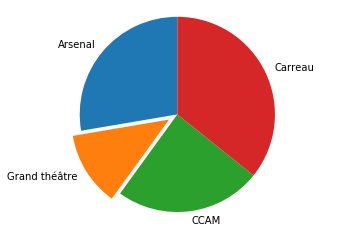

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
sizes = [part_jeune_arsenal, part_jeune_lux, part_jeune_ccam, part_jeune_carreau]
labels = 'Arsenal', 'Grand théâtre', 'CCAM', 'Carreau'
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels,
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [80]:
sizes = [part_jeune_arsenal, part_jeune_lux, part_jeune_ccam, part_jeune_carreau]
sizes

[41.12903225806452, 18.357487922705314, 36.0, 53.125]

## Répartition par pays

### Arsenal

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Répartition des chorégraphes')
ax=df_danse_arsenal.groupby("Pays")["spectacleId"].count().sort_values(ascending=False).head(5).plot.pie(autopct='%1.1f%%')



fig = ax.get_figure()
fig.savefig(os.getcwd() + "/data/arsenal_pays.png")
plt.clf()


<Figure size 432x432 with 0 Axes>

### Luxembourg

In [22]:
#df_danse.Pays.value_counts().head(5)
import pandas as pd
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Répartition des chorégraphes')
ax=df_danse_lux.groupby("Pays")["spectacleId"].count().sort_values(ascending=False).head(5).plot.pie(autopct='%1.1f%%')



fig = ax.get_figure()
fig.savefig(os.getcwd() + "/data/lux_pays.png")
plt.clf()


<Figure size 432x432 with 0 Axes>

### CCAM

In [24]:
#df_danse.Pays.value_counts().head(5)

#df_danse.Pays.value_counts().head(5)
import pandas as pd
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Répartition des chorégraphes')
ax=df_danse_ccam.groupby("Pays")["spectacleId"].count().sort_values(ascending=False).head(5).plot.pie(autopct='%1.1f%%')


fig = ax.get_figure()
fig.savefig(os.getcwd() + "/data/ccam_pays.png")
plt.clf()



<Figure size 432x432 with 0 Axes>

### Carreau

In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Répartition des chorégraphes')
ax=df_danse_carreau.groupby("Pays")["spectacleId"].count().sort_values(ascending=False).head(5).plot.pie(autopct='%1.1f%%')

fig = ax.get_figure()
fig.savefig(os.getcwd() + "/data/carreau_pays.png")
plt.clf()



<Figure size 432x432 with 0 Axes>

## Part de création faite

regarder dans la colonne organismeId

### Arsenal

In [93]:
import re
#Filtre sur le genre - string contains danse
df_danse_cree_arsenal=df_danse_arsenal[df_danse_arsenal['organismeId'].astype(str).str.contains("439",flags=re.IGNORECASE, regex=True)]
df_danse_cree_arsenal

,spectacleId,Genre,Durée,Pays,typeDate,date,organismeId,organismeName,to_analyse
21,38625,Danse,NaN,France,Création le,2011-12-08,?IDX_Organisme=439&Saison=2011,L'Arsenal de Metz,Création le
41,45035,Danse – à partir de 14 ans,1 heure 15,France,Création le,2013-01-11,?IDX_Organisme=439&Saison=2012,L'Arsenal de Metz,Création le
70,59853,Danse – Jeune public – à partir de 12 ans,1 heure,France,Création le,2015-01-15,?IDX_Organisme=439&Saison=2014,L'Arsenal de Metz,Création le
139,90517,Danse,1 heure,France,Création le,2018-10-11,?IDX_Organisme=439&Saison=2018,L'Arsenal de Metz,Création le


### Luxembourg

In [95]:
import re
#Filtre sur le genre - string contains danse
df_danse_cree_lux=df_danse_lux[df_danse_lux['organismeId'].astype(str).str.contains("383",flags=re.IGNORECASE, regex=True)]
len(df_danse_cree_lux)

17

### CCAM

In [96]:
import re
#Filtre sur le genre - string contains danse
df_danse_cree_ccam=df_danse_ccam[df_danse_ccam['organismeId'].astype(str).str.contains("699",flags=re.IGNORECASE, regex=True)]
len(df_danse_cree_ccam)

6

### Carreau

In [97]:
import re
#Filtre sur le genre - string contains danse
df_danse_cree_carreau=df_danse_carreau[df_danse_carreau['organismeId'].astype(str).str.contains("1914",flags=re.IGNORECASE, regex=True)]
len(df_danse_cree_carreau)

0

### Organismes qui font le plus de création

Attention nous sommes sur les spectacles diffusés par Arsenal / Grand théâtre / CCAM / Carreau

# Décalage entre création et diffusion

voir si conforme à l'étude onda 

- garder spectacleId / typeDate / date / to_analyse
- si typeDate et date vide - alors to_analyse


## Date de création

In [2]:
import os
import pandas as pd
import re
organismId="1914"
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_type_spectacle.csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
#Filtre sur le genre - string contains danse
df_danse_arsenal=df_spectacle_arsenal[df_spectacle_arsenal['Genre'].astype(str).str.contains("Danse",flags=re.IGNORECASE, regex=True)]
df_danse_arsenal= df_danse_arsenal[['spectacleId', 'typeDate', 'date','to_analyse']]
#on enlève les performances sans date
df_danse_arsenal.dropna(subset=['typeDate','date','to_analyse'], how='all', inplace=True)
#on transforme le champ date en datetime
df_danse_arsenal['date']= pd.to_datetime(df_danse_arsenal['date'], format='%Y-%m-%d', errors='coerce')
# on garde que l'année 
df_danse_arsenal['date']=df_danse_arsenal.date.dt.year
# on ne garde que l'année dans la colonne to_analyse
#df_danse_arsenal['to_analyse']=df_danse_arsenal['to_analyse'].replace("Création le","")
#df_danse_arsenal['to_analyse'] = df_danse_arsenal['to_analyse'].str[-4:]
#df_danse_arsenal.loc[df_danse_arsenal['to_analyse'] !='','year_creation'] = df_danse_arsenal['to_analyse'] 
#df_danse_arsenal.loc[pd.isna(df_danse_arsenal['year_creation']),'year_creation'] = df_danse_arsenal['date'] 
#df_danse_arsenal= df_danse_arsenal[['spectacleId', 'year_creation']]
#df_danse_arsenal = df_danse_arsenal.astype(int)

#df_danse_arsenal

#################
#df_danse_arsenal = df_danse_arsenal[df_danse_arsenal['spectacleId'] == 63852]
####ici cas Luxembourg 
df_danse_arsenal.loc[pd.notna(df_danse_arsenal['date']),'year_creation'] = df_danse_arsenal['date'] 
df_danse_arsenal['to_analyse']=df_danse_arsenal['to_analyse'].replace("Création le","")
df_danse_arsenal['to_analyse'] = df_danse_arsenal['to_analyse'].str[-4:]
df_danse_arsenal.loc[pd.isna(df_danse_arsenal['year_creation']),'year_creation'] = df_danse_arsenal['to_analyse']
df_danse_arsenal= df_danse_arsenal[['spectacleId', 'year_creation']]
df_danse_arsenal = df_danse_arsenal.astype(int)
df_danse_arsenal
################

#path=os.getcwd() + "/data/"
#df_danse_arsenal.to_csv(os.path.join(path,'all_creation_luxembourg.csv'))

#créer une nouvelle colonne date_year si date NaN alors on prend to_analyse
#fn = lambda row: row.a + row.b # define a function for the new column
#col = df_danse_arsenal.apply(fn, axis=1) # get column data with an index
#df_danse_arsenal = df_danse_arsenal.assign(c=col.values) # assign values to column 'c'df['C'] = df['C'].apply(np.int64)

,spectacleId,year_creation
3,27687,2010
7,10120,2008
10,21054,2010
12,27180,2010
20,12382,2009
...,...,...
218,94433,2018
219,89074,2018
221,74272,2015
223,80629,2017


## Date de diffusion

In [3]:
import os
import pandas as pd

organismId="1914"
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_arsenal_diffusion = pd.read_csv(csv_file_path)
#on enlève les lignes où les performanceId sont nulles
#df_arsenal_diffusion.dropna(subset=['performanceId'], how='all', inplace=True)
df_arsenal_diffusion = df_arsenal_diffusion[~(df_arsenal_diffusion['performanceId']==0)]
df_arsenal_diffusion= df_arsenal_diffusion[['performanceId', 'year','performance','author']]
df_arsenal_diffusion.rename(columns = {'performanceId':'spectacleId'}, inplace = True)
df_arsenal_diffusion.rename(columns = {'year':'year_diffusion'}, inplace = True)
df_arsenal_diffusion

,spectacleId,year_diffusion,performance,author
0,28385,2010,Les Aventures de Nathalie Nicole Nicole,Marion Aubert
1,20089,2010,Le Mardi à Monoprix,Emmanuel Darley
2,28027,2010,Le Triomphe de l'amour,Marivaux
3,27687,2010,Boxe Boxe,Mourad Merzouki
6,28386,2010,Erich von Stroheim,Christophe Pellet
...,...,...,...,...
288,100416,2019,Dehors,Juliette Hulot
289,84619,2019,Formule,Julien Clément
290,47284,2019,A Game of You,Alexander Devriendt
291,82748,2019,Au fond,Philippe Artières


spectacleId
68361    1
30910    1
26064    1
Name: spectacleId, dtype: int64

In [202]:
#spectacleId
#43869     4
#59854     4
#87796     4

## Comparaison date de création et date de diffusion

In [4]:
#join df_arsenal_diffusion et df_danse_arsenal
df_creation_diffusion = df_danse_arsenal.join(df_arsenal_diffusion.set_index('spectacleId'), on='spectacleId')
#path=os.getcwd() + "/data/"
#df_creation_diffusion.to_csv(os.path.join(path,'all_creation_diffusion.csv'))
df_creation_diffusion

,spectacleId,year_creation,year_diffusion,performance,author
3,27687,2010,2010,Boxe Boxe,Mourad Merzouki
7,10120,2008,2010,Three Spells,Damien Jalet
10,21054,2010,2010,Comment ai-je pu tenir là-dedans ?,Alphonse Daudet
12,27180,2010,2010,Gardenia,Alain Platel
20,12382,2009,2010,"Fresque, femmes regardant à gauche",Paco Dècina
...,...,...,...,...,...
218,94433,2018,2019,Go figure out yourself,Wim Vandekeybus
219,89074,2018,2019,TrapTown,Wim Vandekeybus
221,74272,2015,2019,Feu,Bérengère Fournier
223,80629,2017,2019,Rule of Three,Jan Martens


In [5]:
df_creation_diffusion.groupby("spectacleId")["spectacleId"].count().sort_values(ascending=False).head(5)

spectacleId
81139    4
60175    4
74341    4
94433    1
36320    1
Name: spectacleId, dtype: int64

In [8]:
#créer une nouvelle colonne (date de diffusion - date de création)
fn = lambda row: row.year_diffusion - row.year_creation # define a function for the new column
col = df_creation_diffusion.apply(fn, axis=1) # get column data with an index
df_creation_diffusion = df_creation_diffusion.assign(gap_crea_diffu=col.values) # assign values to column 'c'df['C'] = df['C'].apply(np.int64)
df_creation_diffusion.gap_crea_diffu.mean()

1.7611940298507462

In [10]:
df_creation_diffusion = df_creation_diffusion[df_creation_diffusion['gap_crea_diffu'] > 5]
df_creation_diffusion

,spectacleId,year_creation,year_diffusion,performance,author,gap_crea_diffu
62,723,2004,2012,Tigers in the Tea House,Carolyn Carlson,8
111,24948,1987,2014,What the body does not remember,Wim Vandekeybus,27
137,11697,2008,2015,Ali,Mathurin Bolze,7
149,20985,2010,2016,Cinématique,Adrien Mondot,6


# Taille de l'équipe

In [ ]:
## Fonction pour récupérer le nombre de danseurs

In [7]:
import urllib.request
import re
from bs4 import BeautifulSoup
import pandas as pd
import socket, errno
import sys

    

#fallait juste boucler sur les th et prendre tous les td et si nouveau th stop
def import_dancers(spectacleId):
    # specify which URL/web page we are going to be scraping
    url = "https://www.lesarchivesduspectacle.net/?IDX_Spectacle=" + str(spectacleId)    
    try:
        if spectacleId != 0:
            # open the url using urllib.request and put the HTML into the page variable
            page = urllib.request.urlopen(url)
            # parse the HTML from our URL into the BeautifulSoup parse tree format
            soup = BeautifulSoup(page, "lxml")
            #partie sur la taille des équipes
            possible_job=['Danse','Performance']
            #restriction to class == 'f-spectacle__equipe' for case like 74343
            nb_equipe=len(soup.find_all(lambda tag: tag.name == 'table' and tag.get('class') == ['f-spectacle__equipe']))
            #nb_equipe=len(soup.find_all('table', class_='f-spectacle__equipe'))
            #print(soup.find_all('table',class_='f-spectacle__equipe')[1])
            nb_danseurs=0
            job_rowid = {}
            name_rowid = {}
            id_row_dance_start=0
            id_row_dance_end=0
            commentaire=""
            nb_reprise=0
            index_after_dance=0
            new_table= pd.DataFrame(columns=["spectacleId","nombre reprise","commentaire","nb danseur"])
            if nb_equipe > 2:
                nb_reprise=nb_equipe-1
                num_array=1
            if nb_equipe == 1:
                nb_reprise=0
                num_array=0
            if nb_equipe == 2:
                nb_reprise=1
                num_array=0
            if nb_equipe >=1: 
                rows=soup.find_all(lambda tag: tag.name == 'table' and tag.get('class') == ['f-spectacle__equipe'])[num_array].findAll('tr')
                #rows=soup.find_all('table',class_='f-spectacle__equipe')[num_array].findAll('tr')
                for i in range(len(rows)):
                    th_all = rows[i].findAll('th')
                    #on récupère le nombre de row par métiers et la ligne danse
                    for th in th_all:
                        job_rowid[i] = th.getText()
                        if any(x in job_rowid[i] for x in possible_job):
                            id_row_dance_start=i
                
                #ok on n'a maintenant un tableau avec le numéro de ligne du job + le job
                #faut récupérer les td après ces numéros de lignes
                for i in range(len(rows)):
                    td_all = rows[i].findAll('td')
                    #on récupère le nombre de row par métiers et la ligne danse
                    for td in td_all:
                        name_rowid[i] = td.getText()
                #faut récupérer l'id du job qui suit la danse mais parfois les id ne se suivent pas car il ya des lignes vides
                for index, item in enumerate(job_rowid):
                    #print(index,item)
                    if (item==id_row_dance_start):
                        #on récupère l'id de la danse
                        index_dance=index
                        index_after_dance=index_dance + 1
                    #dans le cas où l'élément danse n'est pas le dernier élément
                    if(index==index_after_dance):
                        id_row_dance_end=item
                #cas ou il n'y a pas de danse index_dance=0
                if index_dance ==0 and id_row_dance_start==0 : 
                    commentaire="pas de danseurs"
                else:
                    #si danse alors on va récupérer les danseurs de id_row_dance_start à id_row_dance_end
                    #rows=soup.find_all('table',class_='f-spectacle__equipe')[num_array].findAll('tr')
                    #print(rows)
                    for j in range(len(rows)):
                        #si danse pas le dernier job
                        if id_row_dance_end!=0: 
                            if j>=id_row_dance_start and j<id_row_dance_end:
                                span=rows[j].find('span',class_ ='c_Commentaire')
                                if span:
                                    commentaire=span.getText()
                                anchor=rows[j].find('a',class_ ='c_Personne b')
                                if anchor:
                                    nb_danseurs += 1
                        #que danse https://www.lesarchivesduspectacle.net/?IDX_Spectacle=41661
                        else:
                            span=rows[j].find('span',class_ ='c_Commentaire')
                            if span:
                                commentaire=span.getText()
                            anchor=rows[j].find('a',class_ ='c_Personne b')
                            if anchor:
                                nb_danseurs += 1 
            new_table = new_table.append({"spectacleId":spectacleId,"nombre reprise":nb_reprise,"commentaire":commentaire,"nb danseur":nb_danseurs},ignore_index=True)
            nb_danseurs=0
            commentaire=""
            nb_reprise=0
        return new_table
    except urllib.error.URLError as e:
        print(e.reason + "for spectacleId "  + str(spectacleId))
    except socket.timeout as e: # <-------- this block here
        print("We timed out")
    except Exception as e:
        print("Unexpected error for " + str(spectacleId) + " spectacle id "+ str(e))
        raise   


In [7]:
#un danseur
#import_dancers(55490)

#une reprise
#import_dancers(59854)
#import_dancers(90517)

#import_dancers(74343)
#pas de la danse
#import_dancers(50625)

#erreur
import_dancers(80888)

#import_dancers(41661)

#Spectacle avec reprise
#3 reprises
#import_dancers(24948)
# 1 reprise
#import_dancers(723)

,spectacleId,nombre reprise,commentaire,nb danseur
0,80888,0,,1


NameError: name 'import_df_nb_danseurs' is not defined

In [ ]:
#fallait juste boucler sur les th et prendre tous les td et si nouveau th stop

In [103]:
#Problème si un danseur
#55490	
#90517

#Pas de danse
#67807  Sous la neige 
#83396 Mon théâtre, techniques de pointe expliquées à mes voisins
#86085 Alain Platel
# 20985 reprise pas de danse définie



# c'est un organisme id. 31575

#20985	Satchie Noro en alternance avec Marie Tassin


#41661 que danse

## Récupérer le nombre de danseurs pour un organisme

In [9]:
import urllib.request
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
from datetime import datetime
import pandas as pd
import os
import socket, errno
# 439 Arsenal
# 699 CCAM
# 383 grand theatre 
# 1914 CARREAU

organismId="1914"
print("start",datetime.now()) 
path=os.getcwd() + "/data/"
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_danse.csv"
df = pd.read_csv(csv_file_path)
#Filtre sur le genre - string contains danse
df=df[df['Genre'].astype(str).str.contains("Danse",flags=re.IGNORECASE, regex=True)]
t_array = df["performanceId"].to_numpy()

frames = [ import_dancers(f) for f in t_array ]
result = pd.concat(frames)
result.set_index(['spectacleId'], drop=True, inplace=True)
result.to_csv(os.path.join(path,'all_10_years_organism_' + organismId + '_danse_nb_danseurs.csv'))
print("finish",datetime.now())



start 2020-08-30 06:25:18.775234
finish 2020-08-30 06:25:50.322672


In [9]:
## Analyse du nombre 

organismId="439"
path=os.getcwd() + "/data/"
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_danse_nb_danseurs.csv"
df = pd.read_csv(csv_file_path)
df = df[df['nb danseur'] < 1]
df

,spectacleId,nombre reprise,commentaire,nb danseur
35,50265,0,pas de danseurs,0
70,74342,0,NaN,0
72,74347,0,"Élèves du CRR Gabriel Pierné, Metz",0
79,67807,0,pas de danseurs,0
82,83396,0,pas de danseurs,0
91,68361,1,pas de danseurs,0
98,86085,0,pas de danseurs,0
108,96786,1,Ballet de la Scala de Milan,0
110,98647,0,24 danseurs,0
111,100034,0,21 danseurs,0


# Esthétique

D'après la liste des 30 chorégraphes définies dans Philippe Noisette, *Danse Contemporaine, mode d’emploi*, Paris, Flammarion, 2010

SyntaxError: invalid syntax (<ipython-input-7-b0a23eac6659>, line 1)

## Arsenal

In [17]:
import os
import pandas as pd
organismId="439"
filterChoregraphNoisette=[20588,4367,48218,47910,9113,6591,4676,10350,4182,7824,913,36997,504,10635,4786,6500,11280,4674,53732,2265,2227,7788,434,2412,2413,269,2260,14757,4040,14746,4654,9113]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df.authordId.nunique()




11

In [2]:
#Antonia Baehr
import os
import pandas as pd
organismId="439"
filterChoregraphNoisette=[42962]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df

,Unnamed: 0,organism_id,year,performance,performanceId,author,authordId,label,period,occurency,place
97,97,439,2015,Abecedarium Bestiarium,55490,Antonia Baehr,42962,\nAbecedarium Bestiarium conception Antonia B...,\n22/01 → 23/01\n,[2 rep.],(Studio du Gouverneur)


In [6]:
#François Chaignaud / Cecilia Bengolea
import os
import pandas as pd
organismId="439"
filterChoregraphNoisette=[18144,11289]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_danse.csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
zoom_df =choregraph_zoom_df[["performanceId","performance","author","place","year","occurency"]]
zoom_df

,performanceId,performance,author,place,year,occurency
38,33746,(M)imosa,Cecilia Bengolea,(Studio du Gouverneur),2013,[2 rep.]
47,50278,Dumy Moyi,François Chaignaud,Salle Saint-Pierre-aux-Nonnains,2014,[4 rep.]
63,59854,Dub Love,François Chaignaud,(Grande salle),2015,[1 rep.]
84,81168,Romances inciertos,François Chaignaud,(Grande salle),2017,[1 rep.]


In [5]:
#ballet de lorrraine
#148826 peter jacobson
import os
import pandas as pd
organismId="439"
filterChoregraphNoisette=[148826]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + "_danse.csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,organism_id,year,performance,performanceId,author,authordId,label,...,occurency,place,Genre,Durée,Pays,typeDate,date,organismeId,organismeName,to_analyse
110,173,173,204,439,2019,For Four Walls,98647,Petter Jacobsson,148826,\nFor Four Walls chorégraphie Petter Jacobsso...,...,[1 rep.],(Grande salle),Danse,35 minutes,France,NaN,NaN,NaN,NaN,Création 2019


## Grand théâtre

In [1]:
import os
import pandas as pd
organismId="383"
filterChoregraphNoisette=[20588,4367,48218,47910,9113,6591,4676,10350,4182,7824,913,36997,504,10635,4786,6500,11280,4674,53732,2265,2227,7788,434,2412,2413,269,2260,14757,4040,14746,4654,9113]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df.authordId.nunique()

16

In [1]:
import os
import pandas as pd
organismId="383"
filterChoregraphNoisette=[161754]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df

,Unnamed: 0,organism_id,year,performance,performanceId,author,authordId,label,period,occurency,place
394,394,383,2017,The Great Tamer,80503,Dimitris Papaioannou,161754,\nThe Great Tamer mise en scène Dimitris Papa...,\n29/03\n,[1 rep.],(Grande Salle)


## Anne Teresa De Keersmaeker

Lien spécifique 
- Red Bridge project
https://theatres.lu/ARCHIVES/SAISON+2017-2018/RED+BRIDGE+PROJECT.html

id personne 913


In [4]:
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin([913])]
len(choregraph_zoom_df)

14

In [5]:
choregraph_zoom_df

,Unnamed: 0,organism_id,year,performance,performanceId,author,authordId,label,period,occurency,place
54,54,383,2011,Drumming,24985,Anne Teresa De Keersmaeker,913,\nDrumming chorégraphie Anne Teresa De Keersm...,\n29/06\n,[1 rep.],(Grande Salle)
64,64,383,2012,Fase,4030,Anne Teresa De Keersmaeker,913,\nFase chorégraphie Anne Teresa De Keersmaeker\n,\n20/11\n,[1 rep.],(Studio)
65,65,383,2012,Rosas danst Rosas,4063,Anne Teresa De Keersmaeker,913,\nRosas danst Rosas chorégraphie Anne Teresa ...,\n22/11\n,NaN,(Arrière-scène)
66,66,383,2012,Elena's Aria,26012,Anne Teresa De Keersmaeker,913,\nElena's Aria chorégraphie Anne Teresa De Ke...,\n24/11\n,[1 rep.],(Arrière-scène)
67,67,383,2012,Mikrokosmos,26064,Anne Teresa De Keersmaeker,913,\nMikrokosmos chorégraphie Anne Teresa De Kee...,\n27/11\n,[1 rep.],(Arrière-scène)
155,155,383,2013,Partita 2,42237,Anne Teresa De Keersmaeker,913,\nPartita 2 chorégraphie Anne Teresa De Keers...,\n22/03\n,[1 rep.],(Grande Salle)
186,186,383,2014,Vortex Temporum,50566,Anne Teresa De Keersmaeker,913,\nVortex Temporum chorégraphie Anne Teresa De...,\n20/11\n,[1 rep.],(Grande Salle)
233,233,383,2014,Golden Hours,57851,Anne Teresa De Keersmaeker,913,\nGolden Hours chorégraphie Anne Teresa De Ke...,\n30/06\n,[1 rep.],(Grande Salle)
287,287,383,2015,Verklärte Nacht,65258,Anne Teresa De Keersmaeker,913,\nVerklärte Nacht chorégraphie Anne Teresa De...,\n24/05\n,[1 rep.],(Grande Salle)
329,329,383,2016,Rain,1498,Anne Teresa De Keersmaeker,913,\nRain chorégraphie Anne Teresa De Keersmaeker\n,\n01/03\n,[1 rep.],(Grande Salle)


## CCAM

In [19]:
import os
import pandas as pd
organismId="699"
filterChoregraphNoisette=[20588,4367,48218,47910,9113,6591,4676,10350,4182,7824,913,36997,504,10635,4786,6500,11280,4674,53732,2265,2227,7788,434,2412,2413,269,2260,14757,4040,14746,4654,9113]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df.authordId.nunique()

3

## Carreau

In [20]:
import os
import pandas as pd
organismId="1914"
filterChoregraphNoisette=[20588,4367,48218,47910,9113,6591,4676,10350,4182,7824,913,36997,504,10635,4786,6500,11280,4674,53732,2265,2227,7788,434,2412,2413,269,2260,14757,4040,14746,4654,9113]
csv_file_path = os.getcwd() + "/data/all_10_years_organism_" + organismId + ".csv"
df_spectacle_arsenal = pd.read_csv(csv_file_path)
choregraph_zoom_df = df_spectacle_arsenal[df_spectacle_arsenal.authordId.isin(filterChoregraphNoisette)]
choregraph_zoom_df.authordId.nunique()

8